In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr

from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.preprocessing import StandardScaler , RobustScaler
from sklearn.metrics import r2_score , mean_absolute_error
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression , ElasticNetCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle


from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from keras.layers import Dense
from keras.models import Sequential
from keras.regularizers import l1
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold
from sklearn.svm import SVR

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


In [2]:
# 
#set seed for productivity of the project
SEED = 2021
def seed(SEED=SEED):
    import os
    np.random.seed = SEED
    os.environ['PYTHONHASHSEED'] = str(SEED)
    
seed()

In [3]:
# read the datasets
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")

In [4]:
# check the shape of each dataset
train.shape , test.shape

((1460, 81), (1459, 80))

#### We are mainly going to focus on only training set.
- This is because our main aim is to be able to check out how different models score

In [5]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
# get a copy of training set
df = train.copy()

In [7]:
# number of duplicates in the dataset
print('Number of Duplicates:', len(df[df.duplicated()]))

Number of Duplicates: 0


In [8]:
# number of Nulls values
print('Number of missing Values:', df.isnull().sum().sum())

Number of missing Values: 6965


In [9]:
# sns.displot(df['YearRemodAdd'])

In [10]:
# since we have missing values let check the percentage fot each columns

print("Missing values by percentage for each column for top 25")
df.isnull().sum().sort_values(ascending=False).head(25)/df.shape[0]

Missing values by percentage for each column for top 25


PoolQC          0.995205
MiscFeature     0.963014
Alley           0.937671
Fence           0.807534
FireplaceQu     0.472603
LotFrontage     0.177397
GarageYrBlt     0.055479
GarageCond      0.055479
GarageType      0.055479
GarageFinish    0.055479
GarageQual      0.055479
BsmtFinType2    0.026027
BsmtExposure    0.026027
BsmtQual        0.025342
BsmtCond        0.025342
BsmtFinType1    0.025342
MasVnrArea      0.005479
MasVnrType      0.005479
Electrical      0.000685
Id              0.000000
Functional      0.000000
Fireplaces      0.000000
KitchenQual     0.000000
KitchenAbvGr    0.000000
BedroomAbvGr    0.000000
dtype: float64

## Observation
- We can be able to see that some columns have even over 99% nulls
- We need to come up with a strategy for dealing with these values
- Depending on the on the column description we are going to decide on the method
- Some of the columns are going to be filled with `NONE` as from variable descriptions
- Other columns will be filled with model or other strategy


- Columns to be filled with NONE include;
    - MiscFeature
    - FireplaceQu
    - Alley
    - Fence
    - PoolQC
- Data description says that having a NaN in these columns suggests that they doesn't have the value of that column.

In [11]:
df['MiscFeature'] = df['MiscFeature'].fillna('None')
df['Alley'] = df['Alley'].fillna('None')
df['FireplaceQu'] = df['FireplaceQu'].fillna('None')
df['Fence'] = df['Fence'].fillna('None')
df['PoolQC'] = df['PoolQC'].fillna('None')

In [12]:
# we are going to use median for LotFrontage and MSZoning
df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(lambda i: i.fillna(i.median()))
df['MSZoning'] = df.groupby('Neighborhood')['MSZoning'].transform(lambda i: i.fillna(i.value_counts().index[0]))

In [13]:
# check what is the missing values remaining
df.isnull().sum().sort_values(ascending=False).head(10)

GarageYrBlt     81
GarageCond      81
GarageFinish    81
GarageQual      81
GarageType      81
BsmtExposure    38
BsmtFinType2    38
BsmtCond        37
BsmtFinType1    37
BsmtQual        37
dtype: int64

### THE REST NULLS
- The rest of the columns are going to be filled with mode strategy 

In [14]:
#use mode methods 
df = df.fillna(df.mode().iloc[0])

In [15]:
# check if there is any other method
df.isnull().sum().sort_values(ascending=False).head(5)

Id             0
CentralAir     0
GarageYrBlt    0
GarageType     0
FireplaceQu    0
dtype: int64

In [16]:
# create some features i.e Total floors
# total quality , bathrooms etc
df['Total_House_floors'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
df['Total_Home_Quality'] = (df['OverallQual'] + df['OverallCond'])/2
df['Total_Bathrooms'] = (df['FullBath'] + (0.5 * df['HalfBath']) + df['BsmtFullBath'] + (0.5 * df['BsmtHalfBath']))

In [17]:
# check data description
df.describe().T


,count,mean,std,min,25%,50%,75%,max
Id,1460.0,730.500000,421.610009,1.0,365.75,730.5,1095.25,1460.0
MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
LotFrontage,1460.0,70.199658,22.431902,21.0,60.00,70.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1460.0,103.117123,180.731373,0.0,0.00,0.0,164.25,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0


## Observations
- From the results we can see some data are not normally distributed
- We have many columns with outliers
- Outliers are silent killers by making models overfit or underfit . It results in a model that is not robust 
- In this project, We are going to  imput features that are not normally distributed
- We are going to use a favourable strategy to deal  with these skewed and outliers data

- We are going to use a skew value of 0.4

In [18]:
# select all columns that are skewed for all numerical values
num_cols = df.select_dtypes(exclude='object').columns

skew_coeff = df[num_cols].skew()

skew_coeff_cols = (skew_coeff.sort_values(ascending=False).to_frame()
             .rename(columns={0:'Skew'})
             .query('abs(Skew) > {0}'.format(0.4)))

skew_coeff_cols

,Skew
MiscVal,24.476794
PoolArea,14.828374
LotArea,12.207688
3SsnPorch,10.304342
LowQualFinSF,9.011341
KitchenAbvGr,4.488397
BsmtFinSF2,4.255261
ScreenPorch,4.122214
BsmtHalfBath,4.103403
EnclosedPorch,3.089872


### Observation
- There are many columns that are highly skewed
- The best method to deals with these columns is using `boxcox_normmax`  and `boxcox` method
- boxcox_normmax Normalizes given column to normally distributed
- We are not going to apply for the target column(SalePrice)

In [19]:
# Normalize skewed features
# we are not required to normalize salesprice
for col in skew_coeff_cols.index:
    if col != "SalePrice" and col !='YearRemodAdd' and col !='YearBuilt':
        df[col] = boxcox1p(df[col], boxcox_normmax(df[col] + 1))

### Target Column

- We are going to inspect target column (SalePrice)
- We will apply log transformation to normalize it
- We will plot two graphs with normalized and original set

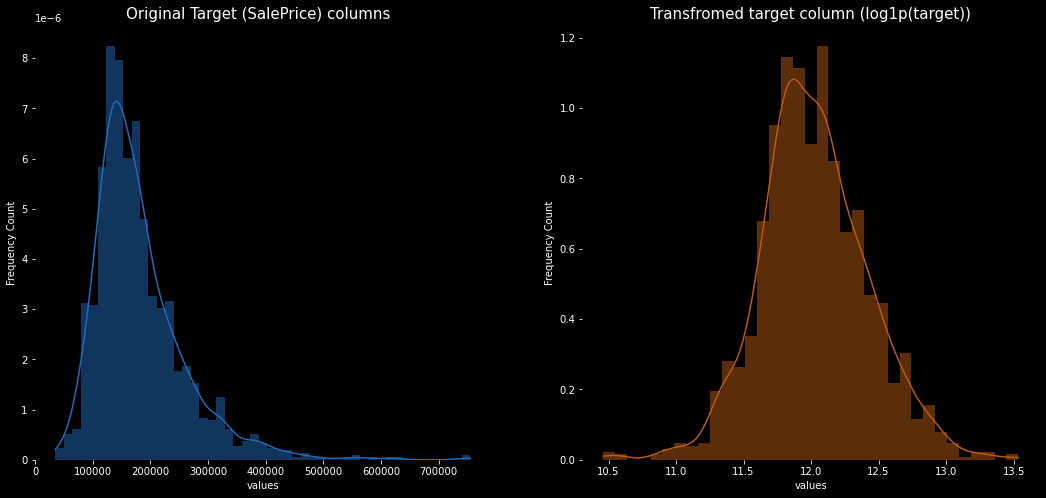

In [20]:
# lets inspect target column
# we are also going to plot log values of the column

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(18, 8))

# set face colors
fig.patch.set_facecolor('black')
ax0.patch.set_facecolor('black')
ax1.patch.set_facecolor('black')

# plot histplot
sns.histplot(df['SalePrice'],kde=True, stat='density', linewidth=0, color = '#236AB9', ax=ax0)
sns.histplot(np.log1p(df["SalePrice"]), kde=True, stat='density', linewidth=0,color='#B85B14', ax=ax1)

# set ticks colors
ax0.tick_params(axis='x', colors='white')
ax0.tick_params(axis='y', colors='white')
ax1.tick_params(axis='x', colors='white')
ax1.tick_params(axis='y', colors='white')

# labeles
ax0.set(ylabel='Frequency Count', xlabel='values');
ax1.set(ylabel='Frequency Count', xlabel='values');

# colors for axis label
ax0.xaxis.label.set_color('white')
ax0.yaxis.label.set_color('white')
ax1.xaxis.label.set_color('white')
ax1.yaxis.label.set_color('white')

# set title
ax0.set_title('Original Target (SalePrice) columns  ', color='white', fontsize= 15)
ax1.set_title('Transfromed target column (log1p(target))', color='white', fontsize= 15)



# Remove axes splines
for i in ['top', 'bottom', 'left', 'right']:
    ax0.spines[i].set_visible(False)

for i in ['top', 'bottom', 'left', 'right']:
    ax1.spines[i].set_visible(False)

# Observation
- We can observe that the target column was skewed to the left
- After log transformation , the target column is now normally distributed
- We are going to use normally distributed columns (log1p(Target)) as our target values for the model

In [21]:
# some columns has not been yet dealt with
# df['YearBuilt']

### Categorical columns
- For categorical columns we will use get dummies to dummisify all categorical columns

In [22]:
# filter all non numerical columns
non_nums = df.dtypes[df.dtypes == np.object]
# get columns that are categorical
category_cols = non_nums.index.tolist()
# create a dummy for the columns
df_enc = pd.get_dummies(df, columns=category_cols, drop_first=True)

In [23]:
df_enc.shape

(1460, 255)

In [24]:
df_enc.head(4)


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,6.281286,10.481395,8.670455,7,3.036929,2003,2003,19.340335,118.098021,...,0,0,0,0,1,0,0,0,1,0
1,2,4.146689,11.558193,8.787627,6,4.241664,1976,1976,0.000000,147.125770,...,0,0,0,0,1,0,0,0,1,0
2,3,6.281286,10.707930,8.933082,7,3.036929,2001,2002,17.687633,91.750453,...,0,0,0,0,1,0,0,0,1,0
3,4,6.622583,10.089353,8.782834,7,3.036929,1915,1970,0.000000,52.861358,...,0,0,0,0,1,0,0,0,0,0


In [25]:
# generate x and y(target features)
X = df_enc[df_enc.columns[df_enc.columns!="SalePrice"]]

# we need to transform the target column using log transfromation
target = np.log1p(df_enc['SalePrice'])

In [26]:
# split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    target, 
    test_size=0.2, 
    random_state=SEED+42)

In [27]:
# check the dimensions of the new dataset
X_test.shape , y_test.shape , X_train.shape , y_train.shape

((292, 254), (292,), (1168, 254), (1168,))

# MODELLING PART

- Since we have formatted the dataset ready for machine leaning purpose.
- We are going to try out different models with our main focus on ridge regression

### Metrics to be used
- For model perfomance testing , we are going to use the following as our metrics
     - RMSE - root mean square ... it measures mean square of the losses. It needs to be as close to 0 as possibel
     - R_squared score - This measures perfectiness of a regression model or line . Values closers to one are better

In [28]:
# define a function to calculate rmse
def rmse(ytrue, preds):
    return np.sqrt(mean_squared_error(ytrue, preds))

def get_model_res(ytrue , preds):
    rm = rmse(ytrue , preds)
    r2_v = r2_score(ytrue , preds)
    
    print("*****Here are the results of the model****\n")
    print(f"MSE score is  {mean_squared_error(ytrue, preds)}")
    print(f"RMSE Score is  {rm}")
    print(f"R_squared score is  {r2_v}")


### Build a RIDGE REGRESSION FROM SCRATCH
- Numpy is used to perfom computation for that is similar to ridge regression

In [29]:
class Custom_Ridge():
    """
    Implimentation of custom ridge regression using numpy 
    """
  # include solver parameter for flexible implementation of gradient descent
  # solution in future, alpha is used in place of lambda to mimic scikit-learn
    
    def __init__(self , alpha =1e-3 , solver ='closed'):
        self.alpha_ = alpha
        self.Features_intercept =None
        self.solver_ = solver
        self.thetas_ = None
    #method for trainig the data
    def fit(self , X, y):
        #get x intercepts for the features
        self.Features_intercept = np.c_[np.ones((X.shape[0], 1)), X]
        if self.solver_ == 'closed':
            Feature_shape = self.Features_intercept.shape[1]
            #generate I (identity matriix compatible with features_intercept)/unit matrix
            I = np.identity(Feature_shape)
            #neet to set the first value in row 1 to be zero
            I[0 ,0] =0
            #create a matrix  to to hold biases .. This represents the ridge X unit matrix
            bias_I = self.alpha_*I
            #generate kernel matrix
            kernel_matrix = self.Features_intercept.T.dot(self.Features_intercept)
            print(f"KERNEL MATRIX SHAPE IS  {kernel_matrix.shape[0]} x {kernel_matrix.shape[1]} \n")
            #add kernel matrix with the biased_I and
            kernel_bias = kernel_matrix+bias_I
            #generate inverse of kernel bias
            kernel_bias_inverse = np.linalg.inv(kernel_bias)
            #multiply bias_kernel_inverse with outcomes and Features_intercept.T
            thetas = kernel_bias_inverse.dot(self.Features_intercept.T).dot(y)
            self.thetas_ = thetas
        #print(self.thetas_)
        return self
    def predict(self , X):
        test_Features_intercept = np.c_[np.ones((X.shape[0], 1)), X]
        preds =  test_Features_intercept.dot(self.thetas_)
        self.preds = preds
        
        return self.preds
    
    def score(self , X , ytrue):
        preds = self.predict(X)
        return  mean_squared_error(ytrue, preds)
        

### Normalize X features

- The scaling function scales data between a range of 0 and -1
- new minimum will be -1 while new maximum will be 1

In [30]:

class Customer_normalizer:
    """
    Scales data between a range of -1 and 1
    """
    def __init__(self):
        print("Started Fitting")
    def fit_normalizer(self , X):
        new_min =-1
        new_max = 1
        scaled_values = ((X - np.min(X))*(new_max - new_min)/(np.max(X) -np.min(X))) +new_min
        return scaled_values.fillna(0)
    


In [31]:
# scale the data
cscaler = Customer_normalizer()

X_test = cscaler.fit_normalizer(X_test)
X_train = cscaler.fit_normalizer(X_train)


Started Fitting


### Shuffling Datapoints

- We are going to reshuffle the datapoints
- We need to set seeds for reproductivity

In [32]:
# create a function for shuffline
def custom_shuffle(X, Y):
    """
    Shuffles data to change their indexes place and return new arrays
    """
    assert len(X) == len(X)
    indexes = np.random.permutation(len(X))
    return X.iloc[indexes], Y.iloc[indexes]


In [33]:
# reshuffle the datapoints
# apply shuffling
X_train , y_train = custom_shuffle(X_train , y_train)
X_test , y_test = custom_shuffle(X_test , y_test)

In [34]:
# recheck the datapoint shape
X_train.shape , y_train.shape , X_test.shape , y_test.shape


((1168, 254), (1168,), (292, 254), (292,))

### Building a Baseline RIDGE model with alpha as 1e-2

In [35]:
alpha_ =1e2
model = Custom_Ridge(alpha=alpha_)
model.fit(X_train.fillna(0),y_train)
predictions = model.predict(X_test.fillna(0))
get_model_res(y_test , predictions)

KERNEL MATRIX SHAPE IS  255 x 255 

*****Here are the results of the model****

MSE score is  0.038975000308298875
RMSE Score is  0.19742087100481265
R_squared score is  0.7880747594913683


### Observation
- The model is able to generate good results
- The model line data point predictions for the test set is over 78%
- Mean absolute loss is also very small to the tune of 0.038



### The model is then trained with a tuned parameters .
- The values of alpha are going to be altered and get different results
-

In [36]:
# get some alphas number
# alphas = np.logspace(-10,2,20)

# 100 values of alphas are genrated and used for taining
alphas = np.geomspace(1e-9, 1e3, num=100)
# list to hold r2_score , mse for each model
mse , r_2 = [] , []
# iterate through all alphas and train RIDGE regressor
for i in range(0,len(alphas)):
    model_test = Custom_Ridge(alpha=alphas[i])
    model_test.fit(X_train,y_train)
    res_pred = model_test.predict(X_test)
    mse.append(mean_squared_error(y_test , res_pred))
    r_2.append(r2_score(y_test , res_pred))
print("done Training")


KERNEL MATRIX SHAPE IS  255 x 255 

KERNEL MATRIX SHAPE IS  255 x 255 

KERNEL MATRIX SHAPE IS  255 x 255 

KERNEL MATRIX SHAPE IS  255 x 255 

KERNEL MATRIX SHAPE IS  255 x 255 

KERNEL MATRIX SHAPE IS  255 x 255 

KERNEL MATRIX SHAPE IS  255 x 255 

KERNEL MATRIX SHAPE IS  255 x 255 

KERNEL MATRIX SHAPE IS  255 x 255 

KERNEL MATRIX SHAPE IS  255 x 255 

KERNEL MATRIX SHAPE IS  255 x 255 

KERNEL MATRIX SHAPE IS  255 x 255 

KERNEL MATRIX SHAPE IS  255 x 255 

KERNEL MATRIX SHAPE IS  255 x 255 

KERNEL MATRIX SHAPE IS  255 x 255 

KERNEL MATRIX SHAPE IS  255 x 255 

KERNEL MATRIX SHAPE IS  255 x 255 

KERNEL MATRIX SHAPE IS  255 x 255 

KERNEL MATRIX SHAPE IS  255 x 255 

KERNEL MATRIX SHAPE IS  255 x 255 

KERNEL MATRIX SHAPE IS  255 x 255 

KERNEL MATRIX SHAPE IS  255 x 255 

KERNEL MATRIX SHAPE IS  255 x 255 

KERNEL MATRIX SHAPE IS  255 x 255 

KERNEL MATRIX SHAPE IS  255 x 255 

KERNEL MATRIX SHAPE IS  255 x 255 

KERNEL MATRIX SHAPE IS  255 x 255 

KERNEL MATRIX SHAPE IS  255 

In [37]:
# check the best top best values of alpha
# r2_score is going to be used as the main metric checker
# For R2 score the maximum score is obtain while
# for the MSE  minimum values of errors are obtained

max_r2_index = np.array(r_2).argmax()
min_mse_index = np.array(mse).argmin()

# print the res with score and alpha
print(f"Best R2 score is {np.round(r_2[max_r2_index] , 5)}  with MSE as {np.round(mse[max_r2_index] , 5)}  and alpha as  {np.round(alphas[max_r2_index] , 6)}")
print(f"Best MSE score is {np.round(mse[min_mse_index] , 5)}  with R2 as {np.round(r_2[min_mse_index] , 5)}  and alpha as  {np.round(alphas[min_mse_index] , 6)}")


Best R2 score is 0.86259  with MSE as 0.02527  and alpha as  3.764936
Best MSE score is 0.02527  with R2 as 0.86259  and alpha as  3.764936


### Observation
- The values obtained resides at the same index.
- The values are used to retrain the model and observe the results


In [38]:
best_alpha_tuned_value = alphas[min_mse_index]
best_alpha_tuned_value

3.7649358067924714

In [39]:
# retrain the model
model_custom_ridge = Custom_Ridge(alpha=best_alpha_tuned_value)
model_custom_ridge.fit(cscaler.fit_normalizer(X_train),y_train)
predictions = model_custom_ridge.predict(cscaler.fit_normalizer(X_test))

get_model_res(y_test , predictions)

KERNEL MATRIX SHAPE IS  255 x 255 

*****Here are the results of the model****

MSE score is  0.025270957154993855
RMSE Score is  0.15896841558936747
R_squared score is  0.8625900287211787


### Try selecting some columns
- This is because working with the current number of datapoints maybe heavy and resources consuming for plynomial features

## Polynomial Features
- Try using different degrees of polynomial features to see the scores

In [40]:
# select new columns
new_cols = ['LotArea' , 'LotFrontage' , "YearBuilt" , "GrLivArea" , "TotalBsmtSF"]
# create a scaling object for the new datapoints
scaler2 = StandardScaler()
scaler2.fit(X[new_cols])

StandardScaler()

In [41]:
# get a sample of 500 rows for training and 100 rows for testing

trainX , trainY = X[new_cols].iloc[:500] , target.iloc[:500]
testX , testY = X[new_cols].iloc[500:700] ,target.iloc[500:700]

In [42]:
# check the sizes of the new data points
trainX.shape , trainY.shape , testX.shape , testY.shape

((500, 5), (500,), (200, 5), (200,))

In [43]:
# scale the data
sm_scaler = StandardScaler()
sm_scaler.fit(X[new_cols])

trainX = sm_scaler.transform(trainX)
testX = sm_scaler.transform(testX)

KERNEL MATRIX SHAPE IS  7 x 7 

KERNEL MATRIX SHAPE IS  22 x 22 

KERNEL MATRIX SHAPE IS  57 x 57 

KERNEL MATRIX SHAPE IS  127 x 127 

KERNEL MATRIX SHAPE IS  253 x 253 



Text(0, 0.5, 'log MSE res')

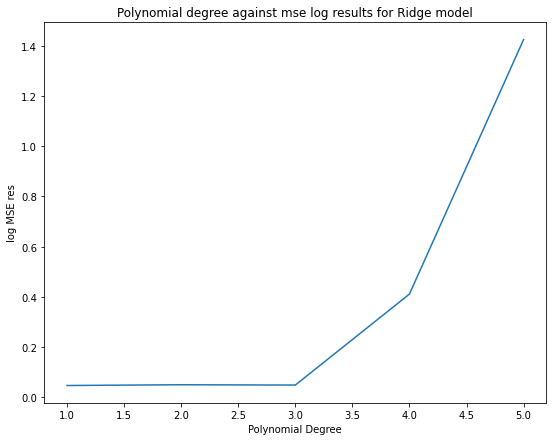

In [44]:
# in order to test different polynomial features 
# it is going to be done from degree 1 to 5 due to computation power
from sklearn.preprocessing import PolynomialFeatures
mse_res =[]
r2_res = []
for deg in range(1,6):
    poly= PolynomialFeatures(degree=deg)
    x_poly = poly.fit_transform(trainX)

    model = Custom_Ridge()
    model.fit(x_poly, trainY)
    y_poly_pred = model.predict(poly.transform(testX))

    mse = mean_squared_error(testY,y_poly_pred)
    r_2 = r2_score(testY,y_poly_pred)
    mse_res.append(mse)
    r2_res.append(r_2)

    
    
# plot the results for mse
plt.figure(figsize=(9,7))
plt.plot(range(1,6) , mse_res)
plt.title("Polynomial degree against mse log results for Ridge model")
plt.xlabel("Polynomial Degree")
plt.ylabel("log MSE res")

Text(0, 0.5, 'R2 score')

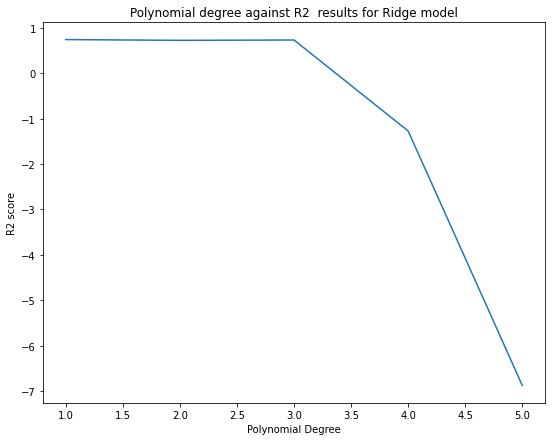

In [45]:

# plot the results for r2
plt.figure(figsize=(9,7))
plt.plot(range(1,6) , r2_res)
plt.title("Polynomial degree against R2  results for Ridge model")
plt.xlabel("Polynomial Degree")
plt.ylabel("R2 score")

### Observation
- Lower polynomial degrees has better results

# COMPAIRING RR MODEL CREATED AGAINST OTHER MODELS

### Since a custom model has been trained and results obtained

- Different models will therefore be tested using different parameters
- Their results will then be compaired to the Custom Ridge model created



### 0. Lasso and Ridge(Original Model)

Best score in Ridge:  0.13114477119702225
Best score in Lasso Regressor is   0.12529799373239742


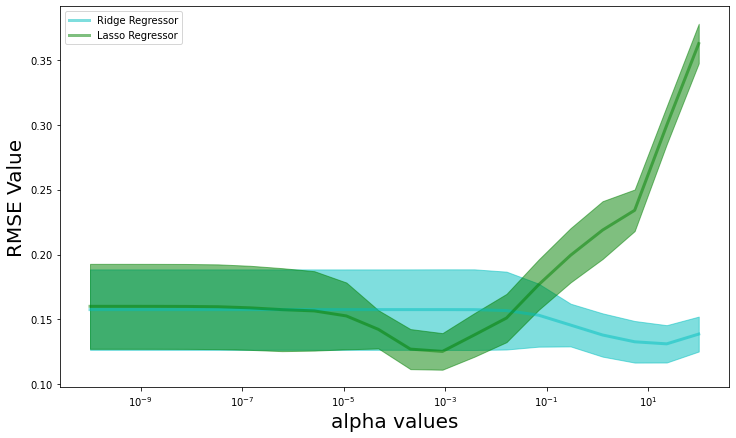

In [46]:
# number of folds for cross validation
cv = 5

# get some alphas number
alphas = np.logspace(-10,2,20)
# results variables
scores = np.zeros((len(alphas),cv))
scores_mu = np.zeros(len(alphas))
scores_sigma = np.zeros(len(alphas))
# iterate through all alphas and train RIDGE regressor
for i in range(0,len(alphas)):
    model = Ridge(alpha=alphas[i])
    #get results for each iteration fold
    cc = np.sqrt(-cross_val_score(model, cscaler.fit_normalizer(X), target,scoring="neg_mean_squared_error", cv = cv))
    scores[i,:] = cc
    #get variation mean and std
    scores_mu[i] = np.mean(scores[i,:])
    scores_sigma[i] = np.std(scores[i,:])

#     plot results for mean against alphas values
plt.figure(figsize = (12,7))   
plt.plot(alphas,scores_mu,'c-',lw=3, alpha=0.5, label = "Ridge Regressor")
# fill the confidence level on the graph for each model
plt.fill_between(
    alphas,
    np.array(scores_mu)-np.array(scores_sigma),
    np.array(scores_mu)+np.array(scores_sigma),
    color="c",
    alpha=0.5
)

# print get the best value from the mean values
print("Best score in Ridge: ",min(scores_mu))

# do the same for Lasso model
for i in range(0,len(alphas)):
    model = Lasso(alpha=alphas[i])
    scores[i,:] = np.sqrt(-cross_val_score(model, X, target,scoring="neg_mean_squared_error", cv = cv))
    scores_mu[i] = np.mean(scores[i,:])
    scores_sigma[i] = np.std(scores[i,:])

plt.plot(
    alphas,scores_mu,
    'g-',
    lw=3, 
    alpha=0.5, 
    label="Lasso Regressor"
)
plt.fill_between(
    alphas,np.array(scores_mu)-np.array(scores_sigma),
    np.array(scores_mu)+np.array(scores_sigma),
    color="g",alpha=0.5
)

plt.xscale("log")
plt.xlabel("alpha values", size=20)
plt.ylabel("RMSE Value", size=20)
plt.legend(loc=2)

print("Best score in Lasso Regressor is  ",min(scores_mu))

### Observation
- LASSO seems to perfom better with lower alpha values
- RIDGE regressions perfoms averagely well with almost same score accross all selected values
- RIDGE had the best results

In [47]:
# lets try cross validation on both of them separately to see the score

### 1. Lasso Regression + Cross-Validation
- Lasso Regression is a linear model that minimizes its cost function.
- The cost funtion has a regularization parameter with an alpha that tunes the intensity of this penalty term. 
- This penalty reduces some features to zero, which makes it easier to understand and interpret the prediction.
- The larger the value of alpha, the more coefficients are forced to be zero hence we need optimum alpha value.
- The Lasso regression helps reduce over-fitting and feature selection.

In [48]:
# create a model instance with some params
lasso = Lasso(max_iter = 100000, normalize = True)
# use Cross Validation builtin
lassocv = LassoCV(alphas = None, cv = 10, max_iter = 100000, normalize = True)
lassocv.fit(X_train, y_train)

# use the best parameters from lassocv to set to lasso model
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, y_train)

# get the best alpha and model results
print('The Lasso 1 Model CV Results:')
print("Best Alpha Value", lassocv.alpha_)
# call the metric function
print("\n")
get_model_res(y_test , lasso.predict(X_test))

The Lasso 1 Model CV Results:
Best Alpha Value 0.0002000887556813876


*****Here are the results of the model****

MSE score is  0.03239519042003771
RMSE Score is  0.1799866395598232
R_squared score is  0.8238522522954904


## Observations
- We can be able to see promising results
- The line is well fit with a score r_squared of about 0.9009 which is about 90% fit
- We also got better values for rmse of about 0.1350


- Lets Try another lasso with our preset parameters

In [49]:
# we are trying same thing as above but different method i.e we are setting alpha values
# get random alpha values
alpha = np.geomspace(1e-9, 1e0, num=12)
# train  the Lasso cross validation model
lasso_cv_model = LassoCV(alphas = alpha, cv = 10, max_iter = 100000, normalize = True)
lasso_cv_model.fit(X_train,y_train)

#train a lasso model with tuned parameters 
lasso_tuned_model = Lasso(max_iter = 100000, normalize = True)
lasso_tuned_model.set_params(alpha = lasso_cv_model.alpha_)
lasso_tuned_model.fit(X_train,y_train)


# get the best alpha and model results
print('The Lasso 1 Model CV Results:')
print("Best Alpha Value", lasso_cv_model.alpha_)
# call the metric function
print("\n")
get_model_res(y_test , lasso_tuned_model.predict(X_test))



The Lasso 1 Model CV Results:
Best Alpha Value 8.111308307896872e-05


*****Here are the results of the model****

MSE score is  0.018390876880611653
RMSE Score is  0.1356129672288445
R_squared score is  0.9000002315520604


### Observation
- Woow a great score with the adjustment of alpha values
- We are able to get a r2_score of about 0.9053 or about 91% 
- RMSE values also greatly reduced to 0.132

- That is not our limit , Ltes try to compaire with other models
- Lets Now try for Ridge Regression

# 2. Ridge Regression and Cross-Validation

- Ridge Regression(RR) is similar to the Lasso Regression since it is a linear model that tries to minimize the cost function with l2 penalty.
- RR model doesn't force some features to zero.
- RR shrinks the coefficients, and it helps to reduce the model complexity and multi-collinearity.


- Since we have seen setting values of alpha is goood.. Lets try use it with RIDGE

In [50]:
# we observed that ridge also score higher with high alpha values , we will increase it to 1e2

#generate random alphas
alphas = np.geomspace(1e-10, 2, num=100)
# train a cross validation model
ridgecv_model = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error', normalize = True)
ridgecv_model.fit(X_train, y_train)
# fit a new ridge with the best values
ridge_model = Ridge(alpha = ridgecv_model.alpha_, normalize = True)
ridge_model.fit(X_train, y_train)


# get the best alpha and model results
print('The RIDGE 1 Model CV Results:')
print("Best Alpha Value", ridgecv_model.alpha_)
# call the metric function
print("\n")
get_model_res(y_test , ridge_model.predict(X_test))

print("\n\n\n")



The RIDGE 1 Model CV Results:
Best Alpha Value 0.4750344950434984


*****Here are the results of the model****

MSE score is  0.018335422677386044
RMSE Score is  0.13540835527169676
R_squared score is  0.9003017618987658






## Obvservation
- It also has a pretty good score
- It has over 90% best fit line with an rmse of 0.1345 which is 0.002 higher than that of lasso


-- Try Using SUPPORT VECTOR MACHINE MODELS

# 3. Support Vector Regression (SVR) + Cross-Validation

In [51]:
kfolds = KFold(shuffle=True, random_state=SEED, n_splits=7)
X_train_scale = cscaler.fit_normalizer(X_train)
X_test_scale = cscaler.fit_normalizer(X_test)

# here we are going to tune parameters to get the best
params = {'C':[20, 30], 'gamma': [1e-4, 3e-4, 5e-4 , 1e-3],'epsilon':[0.1, 0.01, 0.05 ,0.005 ]}
svr_model = SVR(kernel='rbf')
# fit the grid search model
clf = GridSearchCV(svr_model, params, cv=kfolds)
clf.fit(X_train_scale,y_train)

# get the best params
clf.best_params_

{'C': 30, 'epsilon': 0.01, 'gamma': 0.0001}

In [52]:
# use the tuned parameters to train SVR model
svr_tuned = SVR(kernel ='rbf', **clf.best_params_)
svr_tuned.fit(X_train_scale,y_train)

print('SVR Regression RESULTS ...')
get_model_res(y_test , svr_tuned.predict(X_test_scale))



SVR Regression RESULTS ...
*****Here are the results of the model****

MSE score is  0.04747658233334218
RMSE Score is  0.21789121674207562
R_squared score is  0.7418476959606586


## Observation 
- SVR almost perfomed same as RIDGE model
- About 64.5% best fit line with RMSE of about 0.2554

#### Since we have tried out Linear Models like Lasso and Ridge and a SVM one which is SVR
- Lets now Try boosting models ,tree or neural networks
    This models include
        - XGBRegressor
        - RandomForestRegressor
        - Dense Neural Network

## 4. XGBRegssor

In [53]:
## making predictions using the XGBoost algorithm 

xg_model = XGBRegressor(n_estimators=1500 , random_state = SEED)
xg_model.fit(X_train, y_train)
xgb_preds = xg_model.predict(X_test)
print("\n")
print("Mean Absolute Error using XGBoost: ", mean_absolute_error(y_test, xgb_preds))
print("\n")
# get results
get_model_res(y_test , xgb_preds)





Mean Absolute Error using XGBoost:  0.19277484648651066


*****Here are the results of the model****

MSE score is  0.0608677053678412
RMSE Score is  0.24671381268149783
R_squared score is  0.6690339192494725


## Observations
- With no any tuning parameters we are able to get best line as 66%
- It has RMSE of about 0.24


### 5. RandomForest Regressor

In [54]:
## making predictions using the Random Forest algorithm 

forest_model = RandomForestRegressor(n_estimators=1500 , random_state=SEED)
forest_model.fit(cscaler.fit_normalizer(X_train), y_train)
ran_preds = forest_model.predict(cscaler.fit_normalizer(X_test))
print("Mean Absolute Error using Random Forest:", mean_absolute_error(y_test, ran_preds))

print("\n")

    
get_model_res(y_test , ran_preds)

Mean Absolute Error using Random Forest: 0.23603894045687077


*****Here are the results of the model****

MSE score is  0.07827156300699377
RMSE Score is  0.2797705542171902
R_squared score is  0.5744010344058501


### Observation

- Random Forest Does not perfom well like other models
- It had RMSE of over 0.28 and lower line fittness of about 57%



### 7 . Dense Neural Network
- We are just going to create a simple architecture
- We will use few number of epochs

In [55]:
# function for R2_squared keras
from keras import backend as K
def R2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [56]:
dense_model = Sequential()
dense_model.add(Dense(256, activation="relu", input_dim = X_train.shape[1]))
dense_model.add(Dense(128 , activation='relu'))
dense_model.add(Dense(64 , activation='relu'))
dense_model.add(Dense(64 , activation='relu'))
dense_model.add(Dense(1 , activation='relu'))

In [57]:
# check model architecture
dense_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               65280     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 110,657
Trainable params: 110,657
Non-trainable params: 0
_________________________________________________________________


In [58]:
# train the model
# deep learning models perfoms well on scalled data
# we need to scaler the data first
X_tr , y_tr= cscaler.fit_normalizer(X_train) , y_train
X_val , y_val = cscaler.fit_normalizer(X_test) , y_test

In [59]:
# the baseline model is going to be done with a small number of epochs
# compile 
LR = 1e-5
epochs = 40
batch =32

from sklearn.metrics import r2_score
from tensorflow.keras.optimizers import SGD
optimizer = SGD(decay=0.0001,lr=LR , momentum=0.9)
# set early stopping

print("***** Started Compiling model and optimization...................")
dense_model.compile(
    loss="mse", 
    optimizer=optimizer ,
    metrics=[R2]
)

# train 
print("Begin training ......")
history= dense_model.fit(X_tr, y_tr, batch_size=batch,
                    steps_per_epoch=len(X_tr)//batch,
                    validation_data=(X_val, y_val),
                    validation_steps=len(X_val) // batch,
                    epochs=epochs,
                      )

***** Started Compiling model and optimization...................
Begin training ......
Epoch 1/40
36/36 [==============================] - 26s 42ms/step - loss: 129.8287 - R2: -998.2145 - val_loss: 82.7918 - val_R2: -532.6428
Epoch 2/40
36/36 [==============================] - 0s 9ms/step - loss: 32.4724 - R2: -231.6358 - val_loss: 4.9474 - val_R2: -30.3400
Epoch 3/40
36/36 [==============================] - 0s 8ms/step - loss: 0.9570 - R2: -5.9398 - val_loss: 8.5998 - val_R2: -53.8757
Epoch 4/40
36/36 [==============================] - 0s 7ms/step - loss: 0.7214 - R2: -3.8808 - val_loss: 9.1822 - val_R2: -57.6304
Epoch 5/40
36/36 [==============================] - 0s 8ms/step - loss: 0.6053 - R2: -3.6202 - val_loss: 8.9872 - val_R2: -56.3766
Epoch 6/40
36/36 [==============================] - 0s 7ms/step - loss: 0.5527 - R2: -3.1547 - val_loss: 8.8883 - val_R2: -55.7391
Epoch 7/40
36/36 [==============================] - 0s 9ms/step - loss: 0.5512 - R2: -3.5001 - val_loss: 9.0102 - v

In [60]:
def create_review_plots(history , Question):    
    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    plt.title(f"\t\t***********{Question} Evaluation Plots *************")
    axes[0].plot(history.history['R2'] , label ="trainning r2" )
    axes[0].plot(history.history['val_R2'], label = "validation r2")
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('r2_score')
    axes[0].legend(['r2_score Train','r2_score Test'])
    axes[0].grid(True)

    axes[1].plot(history.history['loss'] , label="trainning loss")
    axes[1].plot(history.history['val_loss'] , label="validation loss")
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Error')
    axes[1].legend(['Error Train','Error Test'])
    axes[1].grid(True)
    #axes[1].set_ylim([0 , None])
    #axes[0].set_ylim([0 , None])
    axes[1].set_title(f"{Question} Model Loss Evaluation " , c ='red' , fontsize =15)
    axes[0].set_title(f"{Question} Model R2 Evaluation " , c ='red' , fontsize =15)

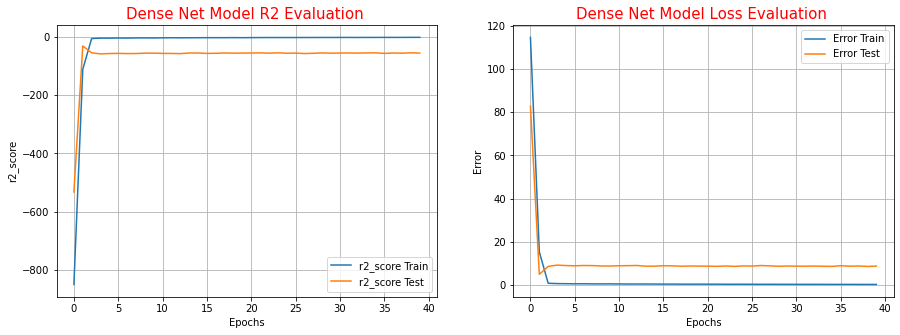

In [61]:
create_review_plots(history , "Dense Net")

In [62]:
# get the model results
print(f"The model R2 score is  {np.round(r2_score(y_test ,  dense_model.predict(X_val)) ,4)}")

print("\n")
get_model_res(y_test ,dense_model.predict(X_val) )


The model R2 score is  -46.4713


*****Here are the results of the model****

MSE score is  8.730414534385165
RMSE Score is  2.954727489022493
R_squared score is  -46.471332528653534


## Observation
- From the dense Net model made , It seems to perfom very bad
- It has r2 values which are very high
- Its RMSE is also very big
- The perfomance maybe due to low amount of data available


- Lets try  DecisionTreeRegressor


## 8. DecisionTreeRegressor

In [63]:
## making predictions using the Decision Tree algorithm 

decision_model = DecisionTreeRegressor()  
decision_model.fit(cscaler.fit_normalizer(X_train), y_train) 
dec_preds = decision_model.predict(cscaler.fit_normalizer(X_test))
print ("Mean Absolute Error using Decision Tress :", mean_absolute_error(y_test, dec_preds))

# get results
print("\n")
get_model_res(y_test , dec_preds)

Mean Absolute Error using Decision Tress : 0.2756030181341429


*****Here are the results of the model****

MSE score is  0.12674959251730644
RMSE Score is  0.3560190901023517
R_squared score is  0.3108033953528493


#### Observation

- Decison tree has poor score also

### Conclusins

- Below is a summarized score for all models

In [64]:
custom = model_custom_ridge.predict(cscaler.fit_normalizer(X_test))
dm = dense_model.predict(X_val)
lm = lasso_tuned_model.predict(X_test)
sv = svr_tuned.predict(X_test_scale)
rd = ridge_model.predict(X_test)
xgb = xg_model.predict(X_test)
forest = forest_model.predict(cscaler.fit_normalizer(X_test))
dec = decision_model.predict(cscaler.fit_normalizer(X_test))
                           
                           
indexes = ["CUSTOM" ,"Neural Net" ,"Lasso tuned" , "svr tuned" , "ridge" , "XGB" , "Random forest" , "Decision tree"]
res_cols = ["R_squared_score" , "RMSE"]
r2_values = [
    r2_score(y_test , custom),
    r2_score(y_test ,dm),
    r2_score(y_test ,lm),
    r2_score(y_test ,sv),
    r2_score(y_test ,rd),
    r2_score(y_test ,xgb),
    r2_score(y_test ,forest),
    r2_score(y_test ,dec),
]

rmse_vals = [
    rmse(y_test , custom),
    rmse(y_test ,dm),
    rmse(y_test ,lm),
    rmse(y_test ,sv),
    rmse(y_test ,rd),
    rmse(y_test ,xgb),
    rmse(y_test ,forest),
    rmse(y_test ,dec),
]


res = pd.DataFrame()

res['R_squared_score'] = r2_values
res['RMSE'] = rmse_vals
res.index = indexes

In [65]:
# check results
res

,R_squared_score,RMSE
CUSTOM,0.862590,0.158968
Neural Net,-46.471333,2.954727
Lasso tuned,0.900000,0.135613
svr tuned,0.741848,0.217891
ridge,0.900302,0.135408
XGB,0.669034,0.246714
Random forest,0.574401,0.279771
Decision tree,0.310803,0.356019


### 
- Since R_squared is the score we are mainly focusing on lets sort the results to get the top three models


In [66]:
res.sort_values(by ='R_squared_score' , ascending = False)

,R_squared_score,RMSE
ridge,0.900302,0.135408
Lasso tuned,0.900000,0.135613
CUSTOM,0.862590,0.158968
svr tuned,0.741848,0.217891
XGB,0.669034,0.246714
Random forest,0.574401,0.279771
Decision tree,0.310803,0.356019
Neural Net,-46.471333,2.954727


### Observation
- The best three models were
      - Lasso Model
      -  RIDGE
      - CUSTOM RIDGE MODEL IS BEST
      
### Lets plot the RESIDUAL plots for the same three models and Predictions  plots

In [67]:
def plot_residual_and_preds(model , name):
    if name == "SVR":
        print("SVR")
        y_train_preds = model.predict(cscaler.fit_normalizer(X_train))
        y_test_preds = model.predict(X_test_scale)
    elif name == "CUSTOM RIDGE MODEL":
        y_train_preds = model.predict(cscaler.fit_normalizer(X_train))
        y_test_preds = model.predict(cscaler.fit_normalizer(X_test))
    else:
        y_train_preds = model.predict(X_train)
        y_test_preds = model.predict(X_test)    
    fig, axes = plt.subplots(1, 2, figsize=(18,8))
    
    plt.title(f"\t\t***********Residual Evaluation Plots *************")
    axes[0].scatter(y_train_preds, y_train_preds - y_train, c = "blue", marker = "s", label = "Training data")
    axes[0].scatter(y_test_preds, y_test_preds - y_test, c = "lightgreen", marker = "s", label = "Validation data")   
    axes[0].set_title(f"{name} Model Residual Plots")
    axes[0].set_xlabel("Predicted values")
    axes[0].set_ylabel("Residuals")
    axes[0].legend(loc = "best")
    axes[0].hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")

    # Plot predictions
    plt.scatter(y_train, y_train_preds, c = "blue", marker = "s", label = "Training data")
    plt.scatter(y_test, y_test_preds, c = "lightgreen", marker = "s", label = "Validation data")
    plt.title(f"{name} Regression plot")
    plt.xlabel("Predicted values")
    plt.ylabel("Real values")
    plt.legend(loc = "best")
    plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
    

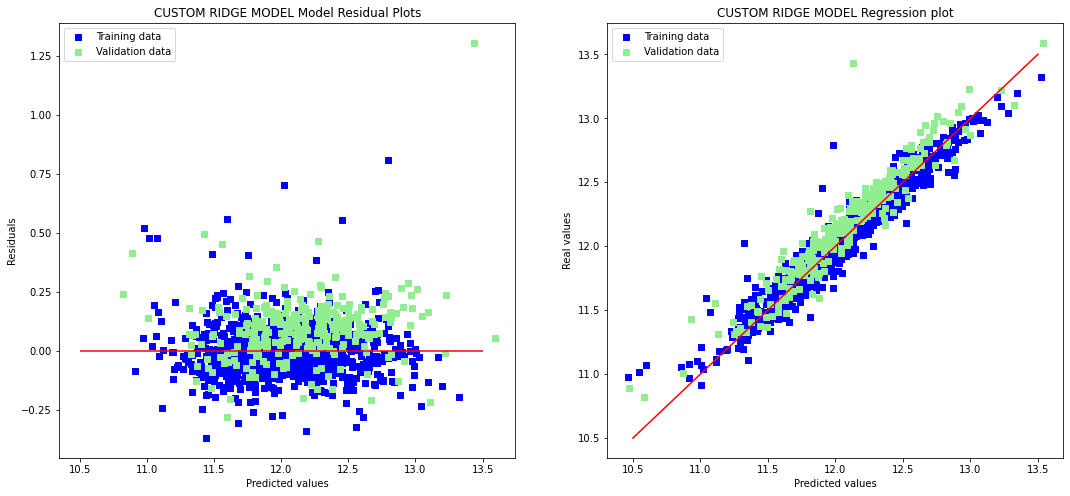

In [68]:
#plot for CUSTOM RIDGE model
plot_residual_and_preds(model_custom_ridge , "CUSTOM RIDGE MODEL")

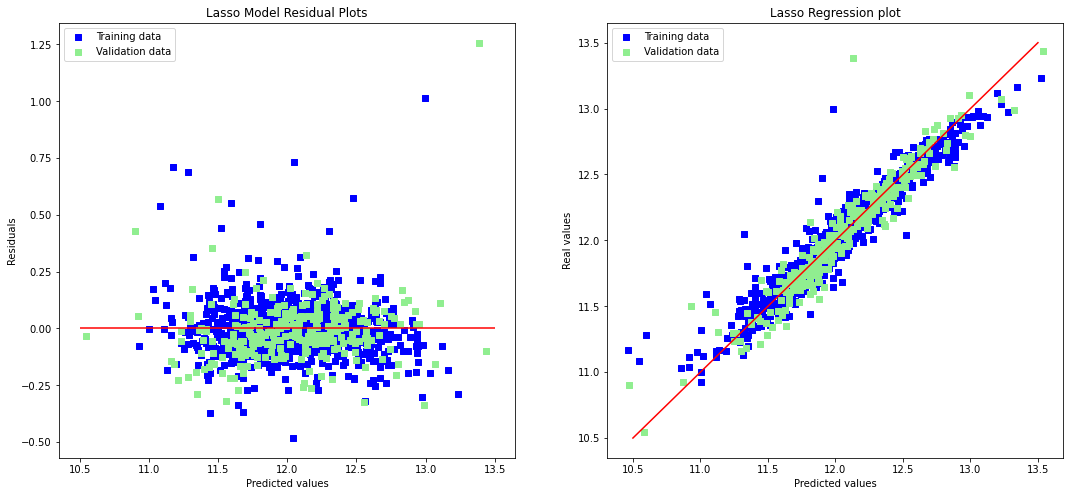

In [69]:
#plot for lasso model
plot_residual_and_preds(lasso_tuned_model , "Lasso")

SVR


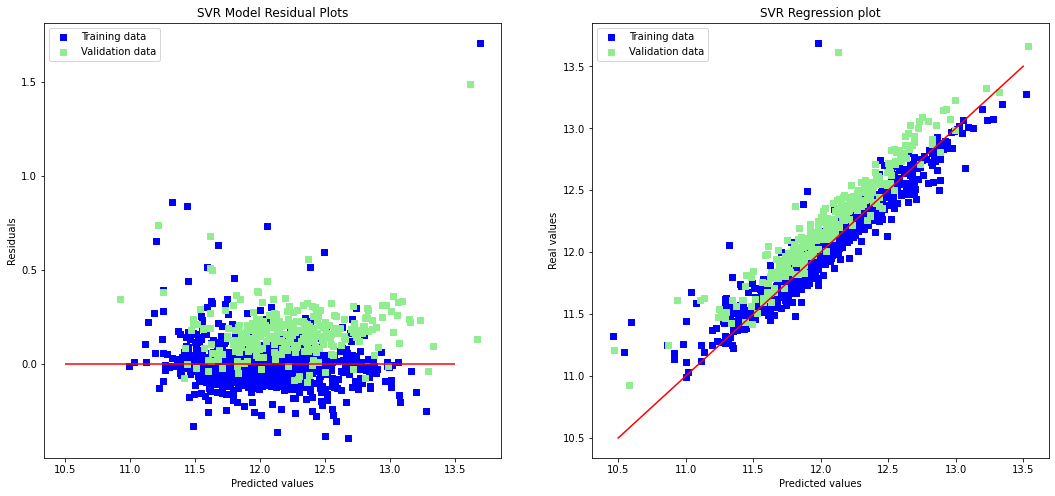

In [70]:
# plot for svr model
plot_residual_and_preds(svr_tuned , "SVR")

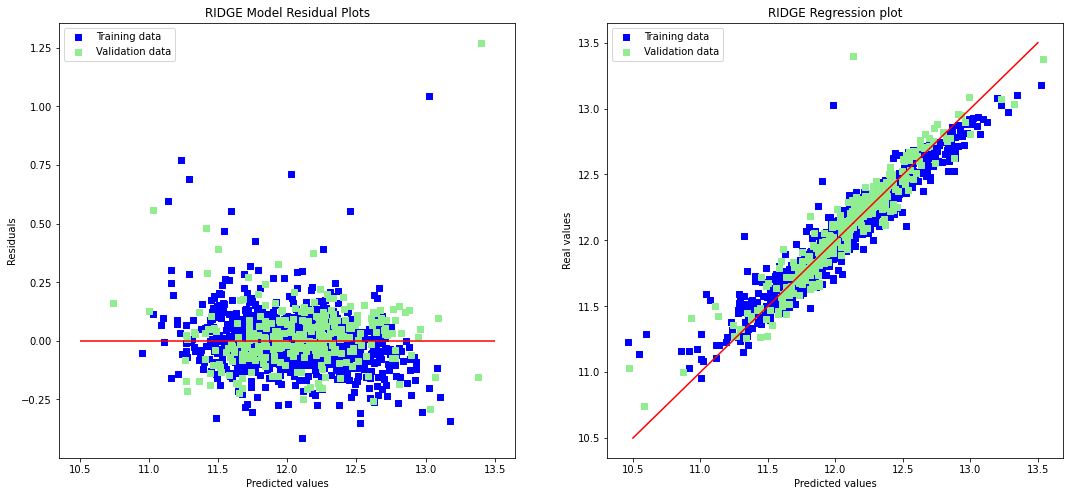

In [71]:
# plot for ridge model
plot_residual_and_preds(ridge_model , "RIDGE")

# THE CUSTOM RIDGE MODEL WAS THE BEST

### Observations

- From the 3 graphs we can see a better graphs with better results for both predictions and test sets
- Lets Analyse features that were used by LASSO model

In [72]:

total_features =  len(lasso_tuned_model.coef_)
total_non_zero = len(lasso_tuned_model.coef_.nonzero()[0])
print()
print(f"Total Features subjected to the model are  {total_features}")
print(f"Total Features used for model creation(non zero features )  {total_non_zero}")
print(f"Total Unused features (Regulated Features )  are {total_features - total_non_zero}")


Total Features subjected to the model are  254
Total Features used for model creation(non zero features )  116
Total Unused features (Regulated Features )  are 138


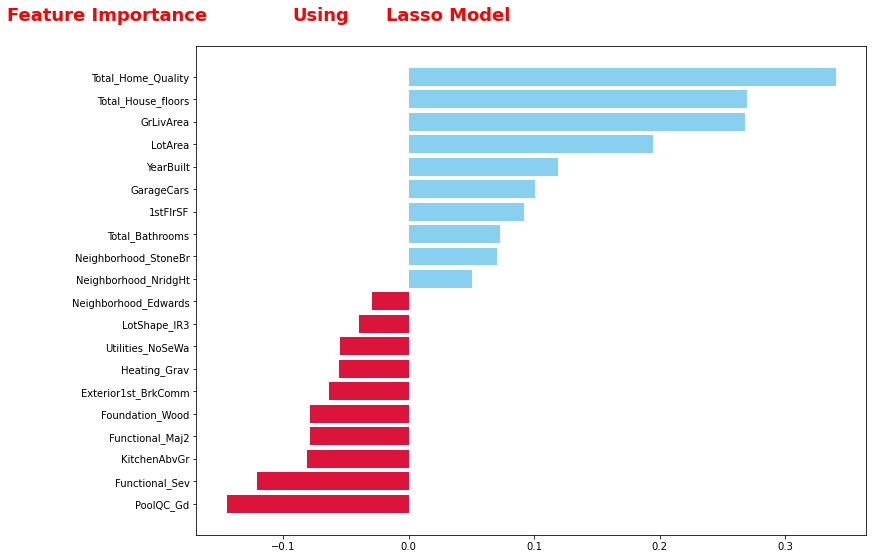

In [73]:

# Selecting features importance
coefs = pd.Series(lasso_tuned_model.coef_, index = X.columns)

# select the top 10 features and bootom 10 features

lasso_coefs = pd.concat([coefs.sort_values().head(10),
                         coefs.sort_values().tail(10)])

lasso_coefs = pd.DataFrame(lasso_coefs, columns=['importance'])

# create plot
fig, ax = plt.subplots(figsize =(12, 9))

# plot these fatures
ax.barh(lasso_coefs.index, 
        lasso_coefs.importance, 
        align='center', 
        color = np.where(lasso_coefs['importance'] < 0, 'crimson', '#89CFF0'))


plt.text(-0.32, 21.5, "Feature Importance", size=18, color="r", fontweight="bold");
plt.text(-0.093, 21.5, "Using", size=18, color="r" , fontweight='bold');
plt.text(-0.0182, 21.5, "Lasso Model", size=18, color="red", fontweight="bold");


### Observation
- All the features in blue positively affect the sale price of the house, which means this characteristic increases the price of the house. 
- All the features in red negatively affect the sale price of the house negatively i.e an increase in them reduces prices of house.





### WE are able to see that we can used Ridge or Lasso to regulate features and get better models